# K Means Clustering 

# Data set ?

Online retail is a transnational data set which contains all the transactions occurring between 
01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. 
The company mainly sells unique all-occasion gifts. 
Many customers of the company are wholesalers.

# Acheive ?

Segement the Customers based on RFM so that the company can target its customers efficiently.

### R (Recency): Number of days since last purchase
### F (Frequency): Number of tracsactions
### M (Monetary): Total amount of transactions (revenue contributed)

In [90]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from Kmeans import Cus_KMeans
#from sklearn.cluster import KMeans
#from sklearn.datasets import make_blobs
import pickle

In [91]:
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

In [92]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [93]:
# shape of df

retail.shape

(541909, 8)

In [94]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Data cleaning

In [95]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [96]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [97]:
# Changing the datatype of Customer Id 

retail['CustomerID'] = retail['CustomerID'].astype(str)

In [98]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [99]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [100]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [101]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [102]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [103]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [104]:
# Compute recency of customer

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [105]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [106]:
# Merge the dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

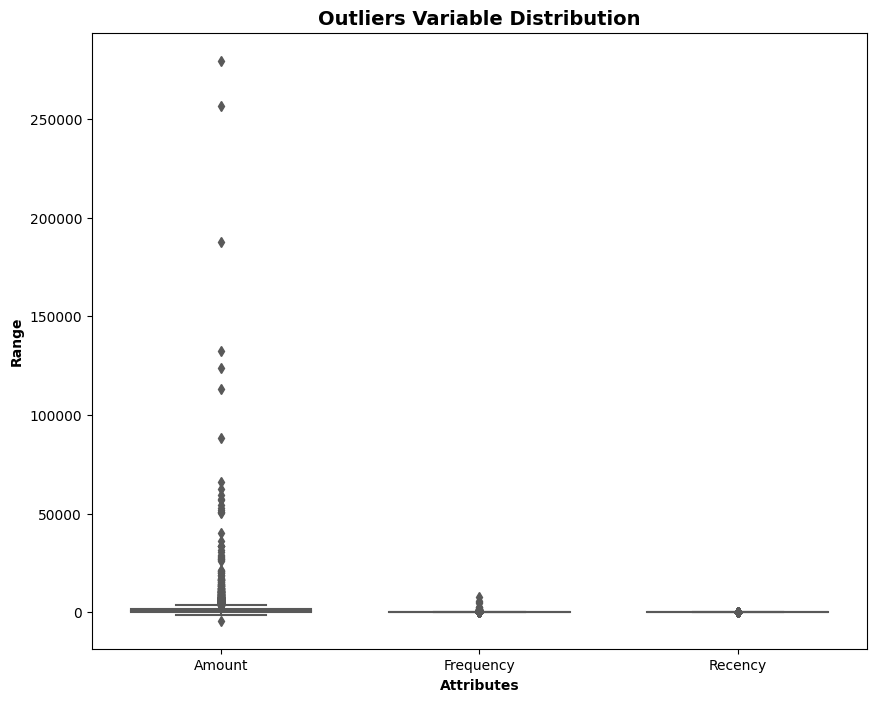

In [107]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [108]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

# Scaling the features

In [109]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [110]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


# Model Building

In [119]:
kmeans = Cus_KMeans(n_clusters=3)
kmeans.fit(rfm_df_scaled)
cluster_labels = kmeans.labels_
cluster_labels

array([0, 1, 2, ..., 0, 2, 2], dtype=int64)

In [36]:
# k-means with some arbitrary k

#kmeans = KMeans(n_clusters=3, max_iter=50, init = 'k-means++')
#kmeans.fit(rfm_df_scaled)

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [120]:
# assign the label
rfm['Cluster_Id'] = cluster_labels
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(rfm[['Amount', 'Frequency', 'Recency']], rfm['Cluster_Id'])
print("Average Silhouette Score:", silhouette_avg)

Average Silhouette Score: 0.05833665617639113


In [121]:
def compute_cohesion(data, labels, cluster_id):
    cluster_data = data[labels == cluster_id]
    if len(cluster_data) == 0:
        return 0
    centroid = np.mean(cluster_data, axis=0)
    cohesion = np.mean(np.linalg.norm(cluster_data - centroid, axis=1))
    return cohesion

def compute_separation(data, labels, cluster_id):
    cluster_data = data[labels == cluster_id]
    other_clusters_data = data[labels != cluster_id]
    if len(cluster_data) == 0 or len(other_clusters_data) == 0:
        return 0
    separation = np.mean(np.min(np.linalg.norm(cluster_data[:, np.newaxis] - other_clusters_data, axis=2), axis=1))
    return separation

In [122]:
cohesion_scores = []
separation_scores = []

for cluster_id in range(3):
    cohesion = compute_cohesion(rfm[['Amount', 'Frequency', 'Recency']].values, rfm['Cluster_Id'].values, cluster_id)
    separation = compute_separation(rfm[['Amount', 'Frequency', 'Recency']].values, rfm['Cluster_Id'].values, cluster_id)
    cohesion_scores.append(cohesion)
    separation_scores.append(separation)

print("Cohesion Scores:", cohesion_scores)
print("Separation Scores:", separation_scores)

Cohesion Scores: [296.8641536223994, 2063.3266255792437, 636.2161267913058]
Separation Scores: [120.07816375917801, 1133.4772697040319, 108.91233023928949]


# Elbow Curve to get the right number of Clusters

In [123]:
def weighted_squared_distance(data, centroids, cluster_labels, weights=None):
    num_samples = data.shape[0]
    num_clusters = centroids.shape[0]

    distances = np.zeros(num_samples)

    for i in range(num_samples):
        sample = data[i]
        cluster_label = cluster_labels[i]
        centroid = centroids[cluster_label]

        distance = np.linalg.norm(sample - centroid)**2

        if weights is not None:
            weight = weights[i]
            distance *= weight

        distances[i] = distance

    total_distance = np.sum(distances)
    return total_distance

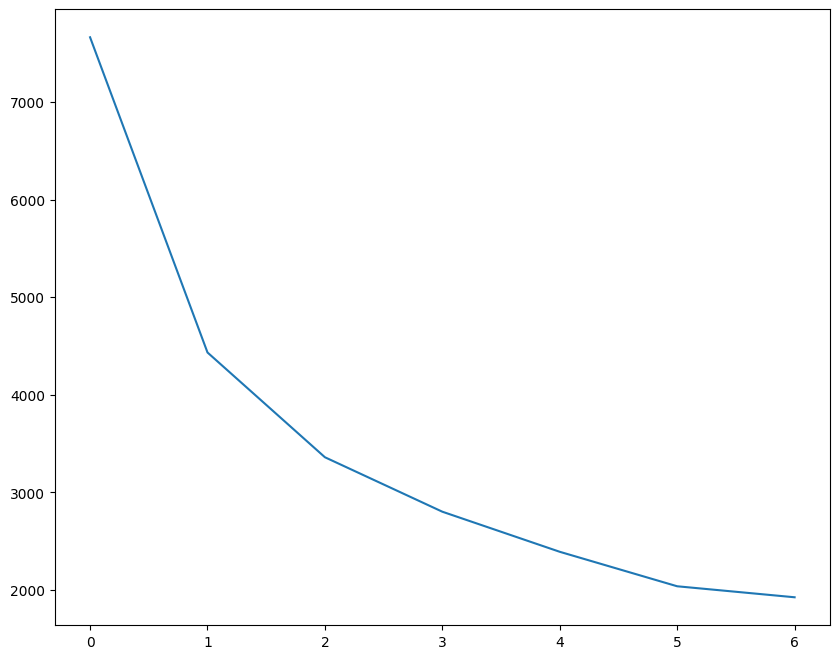

In [124]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    #cluster_labels, centroids = kmeans(data, num_clusters)
    kmeans = Cus_KMeans(n_clusters = num_clusters)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(weighted_squared_distance(rfm_df_scaled.values, kmeans.cluster_centers_, kmeans.labels_))
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [139]:
# Final Model with k=2
model = Cus_KMeans(n_clusters = 2)
model.fit(rfm_df_scaled)
print(model.labels_)

[0 2 1 ... 0 1 1]


In [140]:
with open('kmeans_model_n.pkl', 'wb') as f:
    pickle.dump(model, f)

In [130]:
model.labels_

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [131]:
model.labels_.shape

(4293,)

In [132]:
# assign the label
rfm['Cluster_Id'] = model.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0


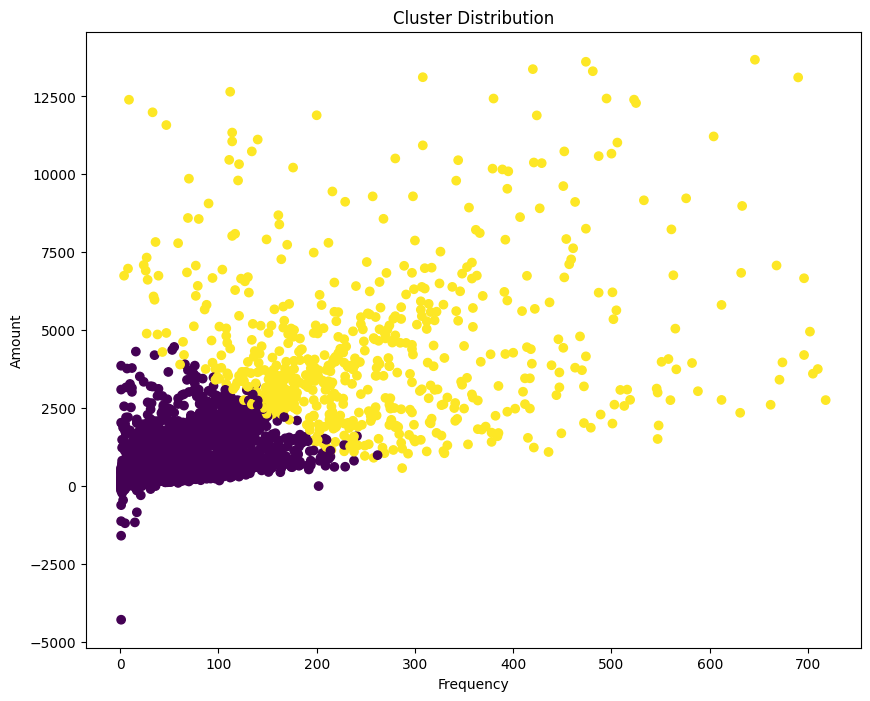

In [133]:
x = rfm.iloc[:, 1]
y = rfm.iloc[:, 2]
plt.scatter(y, x, c= rfm.iloc[:, 4])
plt.xlabel('Frequency')
plt.ylabel('Amount')
plt.title('Cluster Distribution')
plt.show()

In [134]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(rfm[['Amount', 'Frequency', 'Recency']], rfm['Cluster_Id'])
print("Average Silhouette Score:", silhouette_avg)

Average Silhouette Score: 0.6890576646461807


In [135]:
cohesion_scores = []
separation_scores = []
for cluster_id in range(2):
    cohesion = compute_cohesion(rfm[['Amount', 'Frequency', 'Recency']].values, rfm['Cluster_Id'].values, cluster_id)
    separation = compute_separation(rfm[['Amount', 'Frequency', 'Recency']].values, rfm['Cluster_Id'].values, cluster_id)
    cohesion_scores.append(cohesion)
    separation_scores.append(separation)

print("Cohesion Scores:", cohesion_scores)
print("Separation Scores:", separation_scores)


Cohesion Scores: [532.6745534559042, 1954.2061297285024]
Separation Scores: [329.19862391558746, 1066.1527642017693]


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

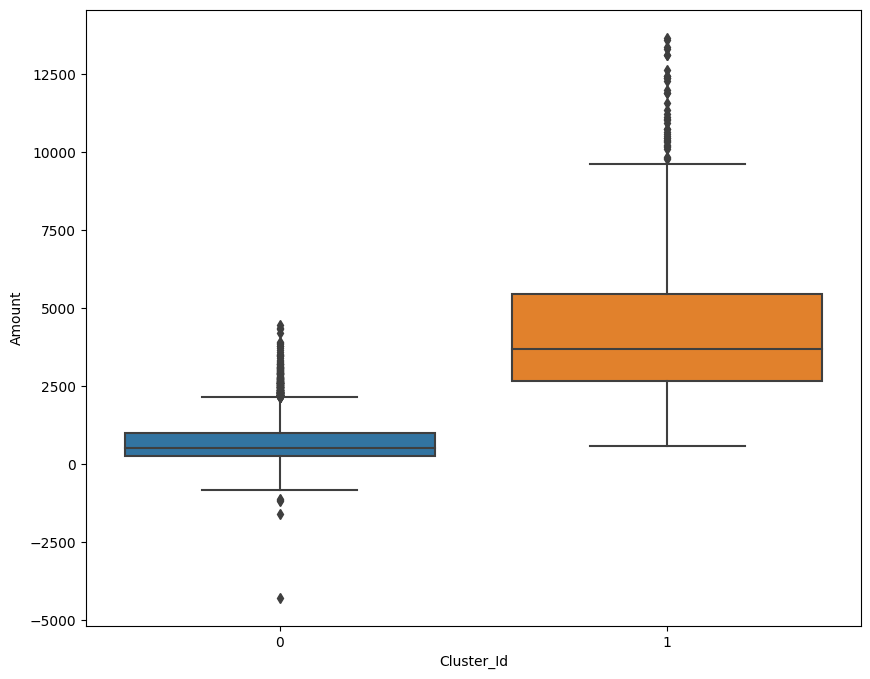

In [136]:
# Box plot to visualize Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

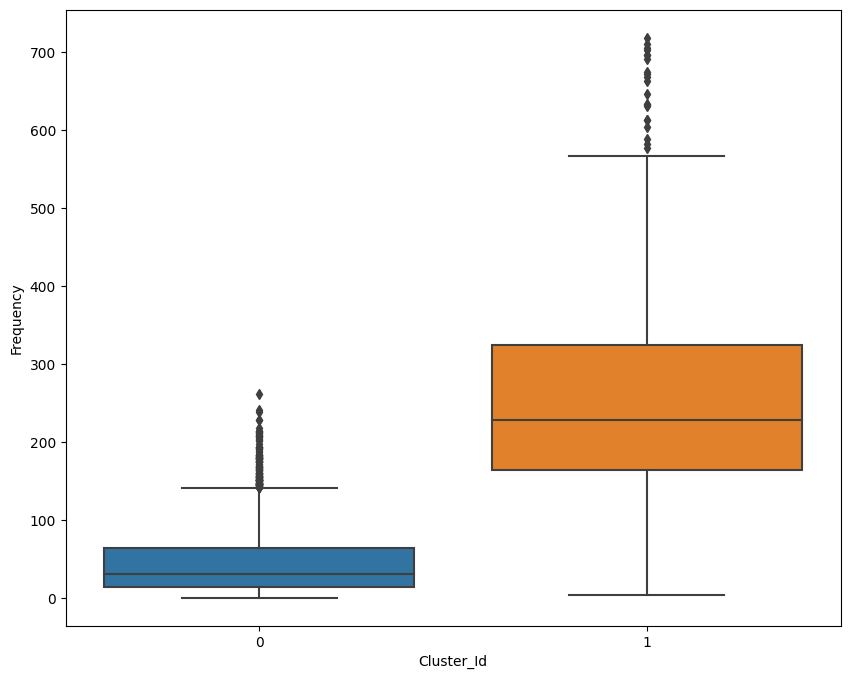

In [137]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

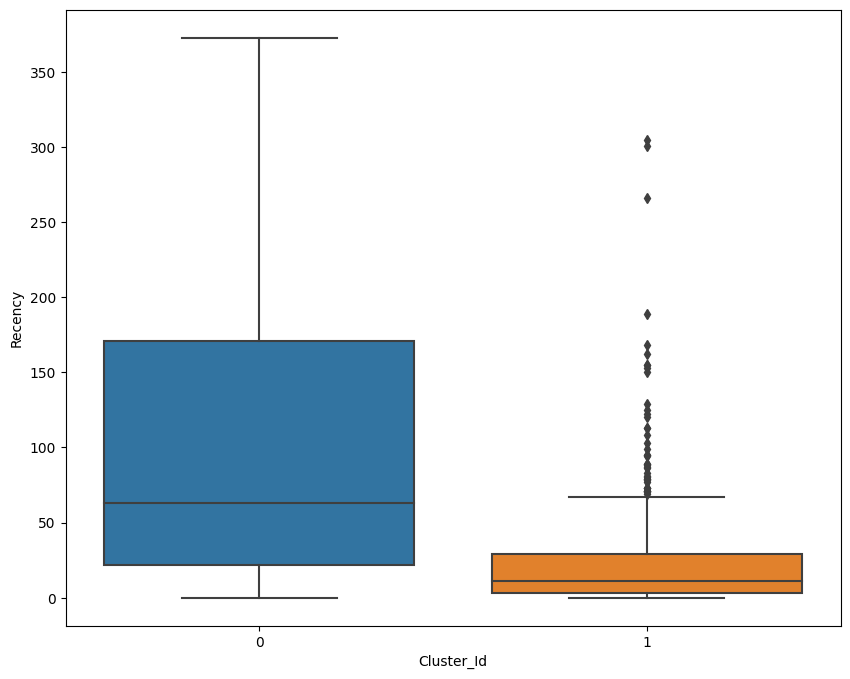

In [138]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)